### Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

### Create trading strategy using linear regression

In [76]:
class Regressionanalysis:

    # The constructor will be called during the object creation and the data feed for
    # the object is stored which could be used for further analysis
    def __init__(self, ticker, start, end, interval):

        self.ticker = ticker
        self.start = start
        self.end = end
        self.interval = interval
        self.data = yf.download(self.ticker, start=self.start,
                                end=self.end, interval=self.interval)

# --------------------------------------------------------------------------------------------------------------------

    def linear_regression(self, independent='Open', dependent='Close'):

        # This function simulates simpnle linear regression fit using given dependent and independent variables and
        # provides summary for the same
        df = self.data
        x = df[independent]
        y = df[dependent]
        x = sm.add_constant(x)

        # Create regression model
        regression_model = sm.OLS(y, x).fit()

        # Generate model summary
        print(regression_model.summary())

        # Generate a component and component-plus-residual (CCPR) plot.
        fig = sm.graphics.plot_ccpr(regression_model, independent)
        fig.tight_layout(pad=1.0)

# ---------------------------------------------------------------------------------------------------------------------

    def rolling_reg(self, period=4):
        
        #Here rolling_reg refers to rolling regression.
        
        df = self.data
        df = df.dropna()
        w = period
        df['a'] = None
        df['b1'] = None

        # Calculate rolling fit by iterating each value
        for i in range(w, len(df)):
            temp = df.iloc[i-w:i, :]
            rolling_least_square = sm.OLS(temp.loc[:, 'Close'], sm.add_constant(temp.loc[:, ['Open']])).fit()
            df.iloc[i, df.columns.get_loc('a')] = rolling_least_square.params[0]
            df.iloc[i, df.columns.get_loc('b1')] = rolling_least_square.params[1]

        # The following line gives you predicted values in a row, given the prior row's estimated parameters
        df['predicted'] = df['a'].shift(1)+df['b1'].shift(1)*df['Open']

# --------------------------------------------------------------------------------------------------------------

        # Calculate profit or loss

        df['pnl'] = 0
        # The position is long profit = buy price (open) - sell price (close)
        df.loc[(df['predicted'] < df['Open']), 'pnl'] = df['Open']-df['Close']
        # The position is short the profit will be cover price(close) - Short price(open)
        df.loc[(df['predicted'] > df['Open']), 'pnl'] = df['Close']-df['Open']

        # Count profit making and loss making trades

        net_profit_trades = df[df["pnl"] > 0].count()["pnl"]
        net_loss_trades = df[df["pnl"] < 0].count()["pnl"]

        # Calculate metrics like returns(%), max drawdown

        df['returns'] = 0

        df.loc[(df['predicted'] < df['Open']), 'returns'] = (( df['Open']-df['Close'])/df['Open'])*100

        df.loc[(df['predicted'] > df['Open']), 'returns'] = ((df['Close']-df['Open'])/df['Open'])*100
        daily_pct_c1 = df['returns']

        daily_pct_c1.reset_index(drop=True)

        # Drawdown and max drawdown

        w = int(252*6.5)
        rolling_max = df['returns'].rolling(w, min_periods=1).max()
        drawdown = df['returns']/rolling_max - 1.0

        # Print the results in a simulated tab
        fig, ax = plt.subplots(3, figsize=(10, 6), constrained_layout=True)
        ax[0].hist(daily_pct_c1, bins=50)
        ax[0].set(title='Retutns(%) Distribution')
        ax[1].set(title='Backtest Estimate')
        ax[1].text(0.5, 0.3, "NET pnl (POINTS) "+str(df["pnl"].sum()),
                   color='green', fontsize=12, ha='center')
        ax[1].text(0.5, 0.5, "Accuracy (%) "+str("%.5f" %
                                                 float((net_profit_trades/(net_profit_trades+net_loss_trades))*100)), color="green", fontsize=12, ha='center')
        ax[1].text(0.5, 0.7, "Total number of trades "+str(net_profit_trades+net_loss_trades),
                   color='green', fontsize=12, ha='center')
        ax[2].plot(df.index, (drawdown), 'r')
        ax[2].set(title='Drawdown Curve')
        plt.show()

        return df

In [77]:
# Enter start and end date
start = '2020-01-20'
end = '2021-11-20'

# Create Regressionanalyis class
ra = Regressionanalysis('^NSEI', start, end, interval='60m')

[*********************100%***********************]  1 of 1 completed


### Analyse output

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.909e+06
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:56:04   Log-Likelihood:                -17298.
No. Observations:                3153   AIC:                         3.460e+04
Df Residuals:                    3151   BIC:                         3.461e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8061      5.193      1.118      0.2

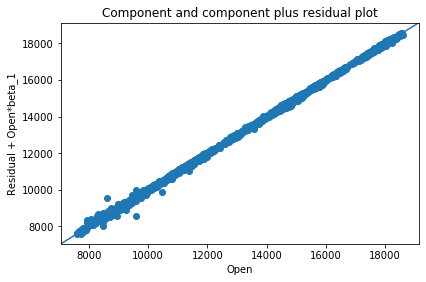

In [78]:
ra.linear_regression(independent='Open', dependent='Close')

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future versi

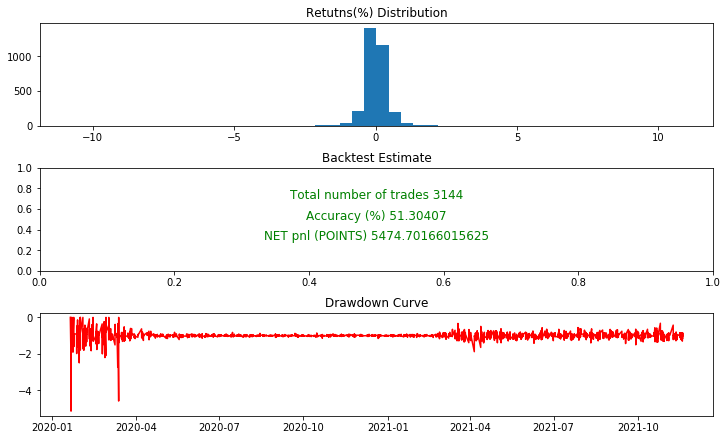

In [79]:
df = ra.rolling_reg(period=4)

In [80]:
df[-10:]

,Open,High,Low,Close,Adj Close,Volume,a,b1,predicted,pnl,returns
Datetime,,,,,,,,,,,
2021-11-17 13:15:00+05:30,17984.550781,18009.400391,17956.300781,17969.300781,17969.300781,0,22998.435691,-0.279325,17973.056029,15.250000,0.084795
2021-11-17 14:15:00+05:30,17969.099609,17976.449219,17894.000000,17894.199219,17894.199219,0,30958.564104,-0.721963,17979.221164,-74.900391,-0.416829
2021-11-17 15:15:00+05:30,17894.900391,17900.250000,17879.949219,17887.199219,17887.199219,0,18213.324017,-0.014605,18039.105032,-7.701172,-0.043036
2021-11-18 09:15:00+05:30,17890.550781,17945.349609,17793.400391,17795.050781,17795.050781,0,5096.533723,0.715126,17952.040824,-95.500000,-0.533801
2021-11-18 10:15:00+05:30,17794.250000,17794.599609,17720.699219,17764.599609,17764.599609,0,-3038.21455,1.166708,17821.664228,-29.650391,-0.166629
2021-11-18 11:15:00+05:30,17764.800781,17770.199219,17708.599609,17719.949219,17719.949219,0,4307.473054,0.756283,17688.126705,44.851562,0.252474
2021-11-18 12:15:00+05:30,17719.900391,17752.650391,17688.849609,17745.199219,17745.199219,0,1582.941421,0.90876,17708.736174,-25.298828,-0.142771
2021-11-18 13:15:00+05:30,17745.650391,17821.599609,17744.449219,17803.099609,17803.099609,0,11361.11297,0.359428,17709.479553,-57.449219,-0.323737
2021-11-18 14:15:00+05:30,17803.650391,17832.400391,17750.300781,17752.250000,17752.250000,0,18283.118731,-0.029562,17760.252228,51.400391,0.288707
